## Basic Co-Occurrence Analysis of Human-Cell-Atlas Pancreas Topograhic Maps

Data from Tosti et al, 2021

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal
from scipy import stats

In [3]:
from sonar import sonar, utils
import math

In [4]:
# Define the cluster labels of the pancreas tissue matrix:

cluster_labels = ['background',
 'Acinar-i',
 'Acinar-s',
 'Acinar-REG+',
 'Activated Stellate',
 'Quiescent Stellate',
 'Alpha',
 'Beta',
 'Gamma (PP)',
 'Delta',
 'Ductal',
 'MUC5B+ Ductal (PDG)',
 'MHC Class II',
 'Schwan',
 'B cell',
 'T cell',
# 'Endothelial'
]

In [5]:
def create_mat(radius=20,size=500):
    span = np.linspace(-1,1,size)
    X,Y = np.meshgrid(span,span)
    
    cone = 1-(X**2+Y**2)**0.5
    
    return (cone>(1-(radius/size*2)))

In [8]:
import torch

if torch.cuda.is_available():
    import torch as t
    device = 'cuda:0' # put it in a gpu
else:
    import torch as t
    device='cpu'


In [148]:
sample_list = []
for sample in range(1,5):
    n_sample = sample

    tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]
    # Islet stack
    rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
    rescaled_splitted = np.split(rescaled, 16)
    islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])
    sample_list.append(islet_stack)


Text(0.5, 1.0, 'Sample4, scaling = 0.3')

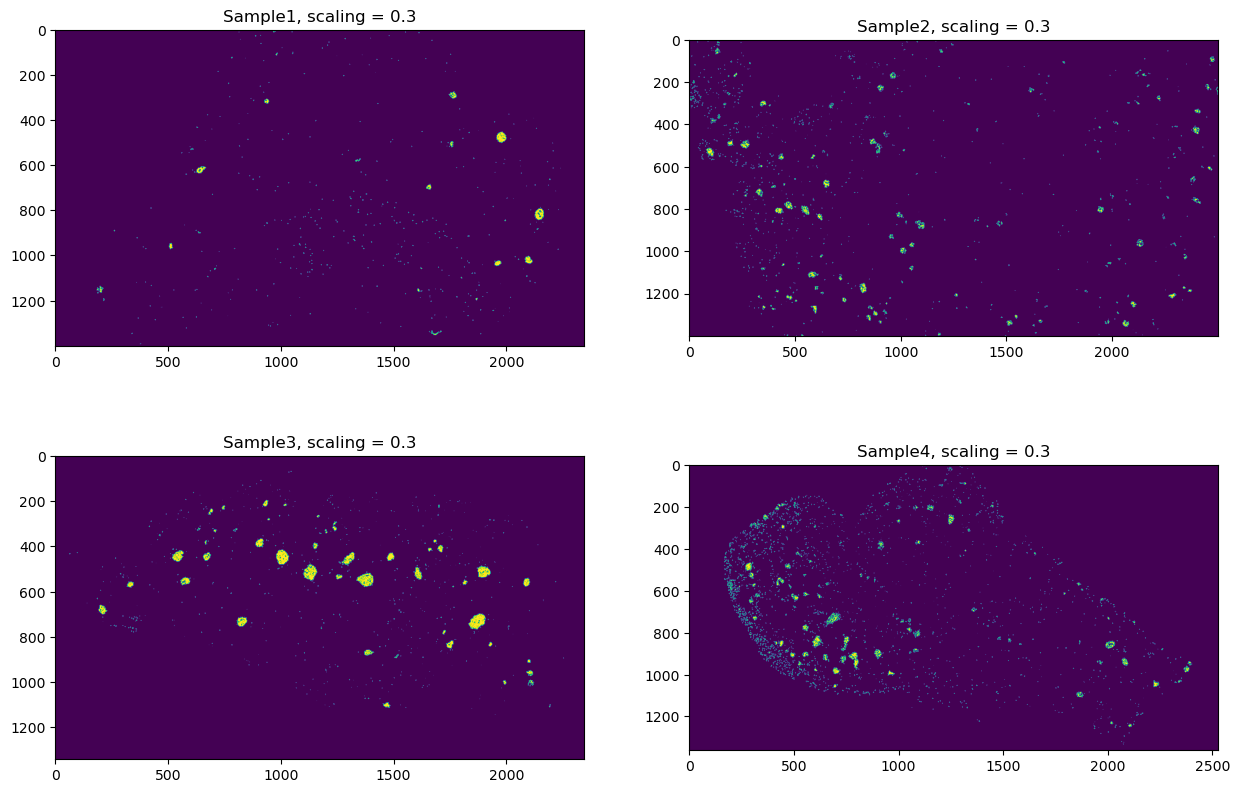

In [41]:
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
plt.imshow(sample_list[0][0][200:1600,:])
plt.title("Sample1, scaling = 0.3")

plt.subplot(2,2,2)
plt.imshow(sample_list[1][0][350:1750,500:3000])
plt.title("Sample2, scaling = 0.3")

plt.subplot(2,2,3)
plt.imshow(sample_list[2][0].T)
plt.title("Sample3, scaling = 0.3")

plt.subplot(2,2,4)
plt.imshow(sample_list[3][0][200:,:])
plt.title("Sample4, scaling = 0.3")

In [5]:
def create_circle_matrix(circles, matrix_size): 
    ''' Create a matrix filled with zeros 
    Input:
        circles - a tuple of 3 values for radius, x coordinate of the circle center, y coordinate of the circle center
        matrix_size - a tuple of 2 values of width and height of the matrix
    Returns:
        matrix with values of type int()
    '''
    matrix = np.zeros(matrix_size) 

    for circle in circles:
        radius, center_x, center_y = circle
 
        for i in range(matrix_size[0]): 
            for j in range(matrix_size[1]): 
                distance = np.sqrt((i - center_x)**2 + (j - center_y)**2) 
                if distance <= radius: 
                    matrix[i, j] = 1 
    return matrix 

Simulation of 4 islets locations

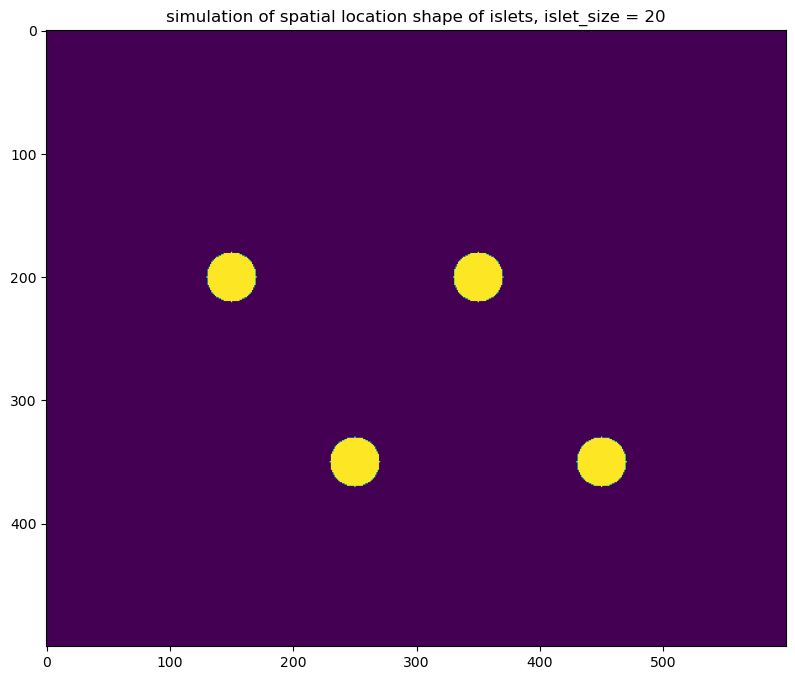

In [22]:
x_lim = 500
y_lim = 600

circles = [
    (20,y_lim//2-100,x_lim//2-100),
    (20,y_lim//2-100,x_lim//2+100),
    (20,y_lim//2+50,x_lim//2),
    (20,y_lim//2+50,x_lim//2+200)
]
matrix_size = (x_lim, y_lim) 
circle_matrix = create_circle_matrix(circles, matrix_size) 

plt.figure(figsize=(12,8))
plt.title("simulation of spatial location shape of islets, islet_size = 20")
plt.imshow(circle_matrix)

Creating a sample simulation by adding noise to the background

In [47]:
bg_noise = np.random.random([1,500,600])<0.3
circle_matrix_bool = circle_matrix.astype(bool)
circle_matrix_bool

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

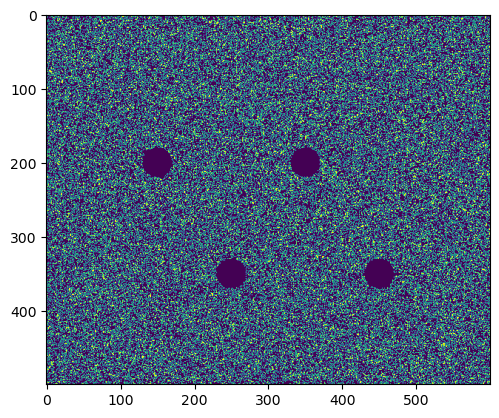

In [48]:
bg_noise_int = bg_noise.squeeze().astype(int)
bg_noise_int[circle_matrix_bool] = False
plt.imshow(bg_noise_int)

In [98]:
three_classes = np.stack((bg_noise_int.astype(int),circle_matrix.astype(int)), axis = 0)
three_classes.shape
# plt.imshow(three_classes, cmap="Greys")

(2, 500, 600)

In [115]:
rescaled.shape

(16, 1788, 2343)

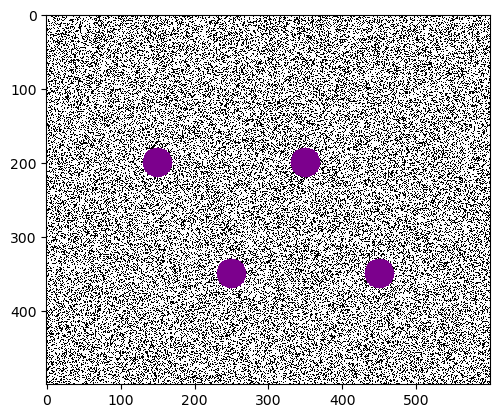

In [131]:
plt.imshow(three_classes.argmax(axis=0),cmap='nipy_spectral',interpolation='none',vmax=len(cluster_labels)-1,alpha=(three_classes.sum(0)!=0).astype(float))

In [110]:
circle_matrix_exp = np.expand_dims(circle_matrix, axis = 0) # was testing sonar for just 1-d matrix, but it also didn't work

In [111]:
circle_matrix_exp.shape

(1, 500, 600)

In [133]:
rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor(three_classes,interpolate=True)

In [134]:
cooc_template_.shape

(2, 2, 500)

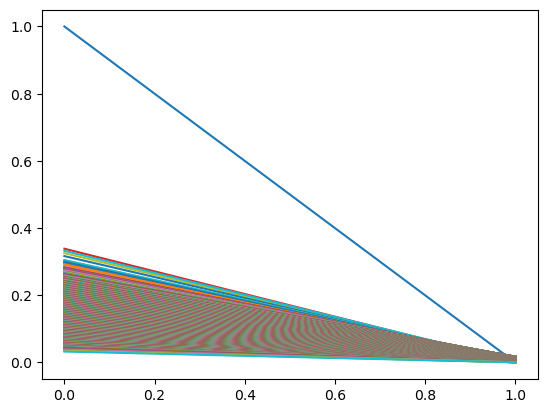

In [135]:
plt.plot(cooc_template_[0])

Sample simulation, "islets" of similar size

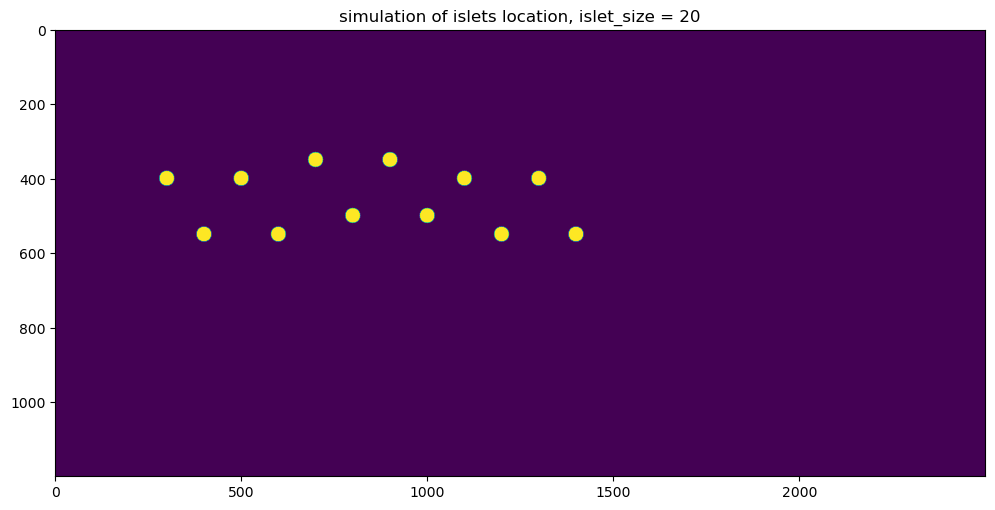

In [19]:
circles = [
    (20,400,500),
    (20,400,300),
    (20,550,400),
    (20,550,600)

]
matrix_size = (1200, 2500) 
circle_matrix = create_circle_matrix(circles, matrix_size) 
circle_matrix += np.roll(np.roll(circle_matrix,400,1),-50,0) + np.roll(circle_matrix,800,1)

plt.figure(figsize=(12,8))
plt.title("simulation of islets location, islet_size = 20")
plt.imshow(circle_matrix)

Sample simulation, "islets" of different size

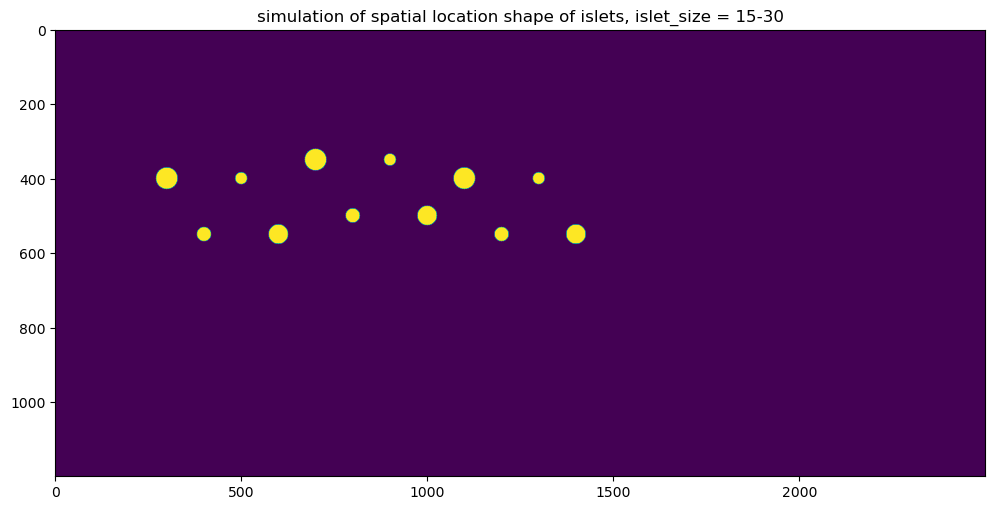

In [21]:
import random

circles = [
    (random.randint(15,30),400,500),
    (random.randint(15,30),400,300),
    (random.randint(15,30),550,400),
    (random.randint(15,30),550,600)

]
matrix_size = (1200, 2500) 
circle_matrix = create_circle_matrix(circles, matrix_size) 
circle_matrix += np.roll(np.roll(circle_matrix,400,1),-50,0) + np.roll(circle_matrix,800,1)

plt.figure(figsize=(12,8))
plt.title("simulation of spatial location shape of islets, islet_size = 15-30")
plt.imshow(circle_matrix)

Real sample, islet cells are combined together

In [142]:
n_sample = 1

# Load the pancreas tissue matrix:
tissue_matrix = np.load('/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/test/ISS-pancreas/data/sample_matrices.npz')['sample_'+str(n_sample)]

In [146]:
# Islet stack
rescaled = utils.rescale_topographic_tensor(tissue_matrix, scaling_factor=0.3).numpy()
# rescaled_splitted = np.split(rescaled, 16)
# islet_stack = np.add.reduce([rescaled_splitted[6],rescaled_splitted[7],rescaled_splitted[8],rescaled_splitted[9]])

def sig(t, k=1):
    return ((1)/(1+(torch.exp(-t*k))))

def smax(t,k=5):
    return (torch.exp(t*k)/(torch.exp(t*k).sum(0)))

rad_ = 500
lin = 1

son = sonar.Sonar(max_radius=rad_,linear_steps=lin)
cooc_template_ = son.co_occurrence_from_tensor(rescaled,interpolate=True) 

/dh-projects/ag-ishaque/analysis/anastasiia/projects/sonar/sonar/sonar.py:204: RuntimeWarning: invalid value encountered in divide
  co_occurrences = co_occurrences/(co_occurrences[:,:,0].diagonal()[:,None,None])


(-0.001, 0.01)

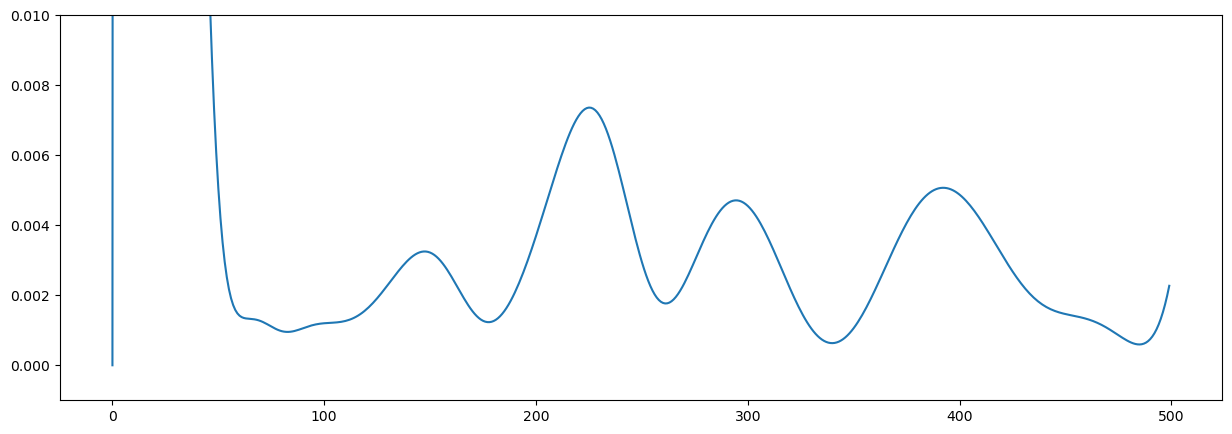

In [93]:
# plt.figure(figsize=[15,5])
# plt.plot(cooc_template_[6,7])
# plt.ylim(-0.001,0.01)

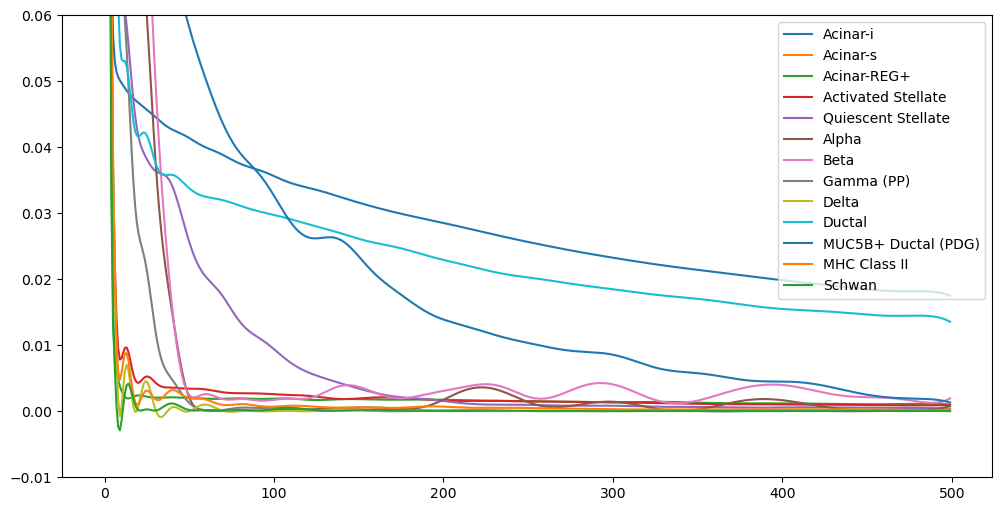

In [147]:
plt.figure(figsize=[12,6])

for i in range(1,14):
    # plt.plot(cooc_template_[6,7])
    plt.plot(cooc_template_[i,i])

# plt.plot(cooc_template_islet[0,0])
plt.ylim(-0.01,0.06)
plt.legend(cluster_labels[1:14], loc="upper right")

In [14]:
local_list = []
for cell_type in range(1,14):
    sonar_val = cooc_template_[cell_type,cell_type][100]
    local_list.append(sonar_val)
local_list

[0.03563394316126394,
 0.3276290315699943,
 0.0019263836603150332,
 0.00257796019133952,
 0.009405658405508157,
 0.00015629668155731034,
 0.0017370545505233034,
 0.0005592099706216646,
 1.1591155657696715e-05,
 0.029742650152775694,
 0.03264450108582401,
 0.000706393000517844,
 0.00032614507692515203]

In [135]:
scipy.stats.ttest_1samp(local_list, 0)

TtestResult(statistic=1.376993664703207, pvalue=0.19365916551061593, df=12)

In [165]:
mat_inv = np.invert(mat)
mat_inv

array([[[False,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ..., False,  True,  True],
        ...,
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]])

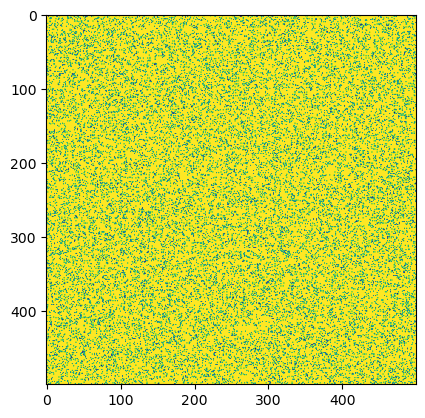

In [166]:
plt.imshow(mat_inv[0])

In [167]:
final_arr = np.concatenate([mat,mat_inv])
final_arr = final_arr.astype(int)

final_arr

array([[[1, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 1, 1],
        ...,
        [1, 0, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]]])

In [171]:
test_layer1 = np.sum(final_arr[0])/(500*500)
test_layer2 = np.sum(final_arr[1])/(500*500)
print(test_layer1, test_layer2)

0.100728 0.899272


In [172]:
mat1 = np.roll(create_mat(radius=rad_cell,size=2000),-150,1)
mat1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

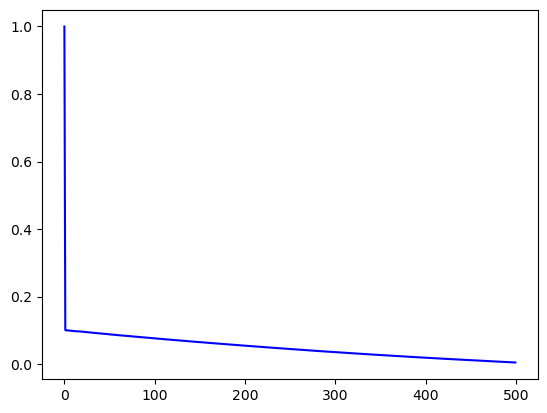

In [179]:
rad_ = 500
rad_cell=50
conveds = []

son = sonar.Sonar(linear_steps=rad_, max_radius=rad_, normalize=True)
#radii, 
co_occurrence_test = son.co_occurrence_from_tensor(hists=final_arr, interpolate=True)

plt.plot(co_occurrence_test[0,0], color = 'blue')

numpy.random.choice

In [261]:
training_matrix = np.random.choice(range(1,4), size=(1,500,500))
training_matrix

array([[[1, 3, 1, ..., 2, 2, 3],
        [2, 2, 1, ..., 2, 3, 2],
        [3, 1, 1, ..., 1, 2, 3],
        ...,
        [1, 3, 3, ..., 1, 2, 2],
        [3, 2, 1, ..., 3, 2, 3],
        [2, 1, 3, ..., 1, 1, 3]]])

In [262]:
layer1 = training_matrix.copy()
for i in range(500):
    for j in range(500):
        if layer1[0,i,j] != 1:
            layer1[0,i,j] = 0

print(layer1)

[[[1 0 1 ... 0 0 0]
  [0 0 1 ... 0 0 0]
  [0 1 1 ... 1 0 0]
  ...
  [1 0 0 ... 1 0 0]
  [0 0 1 ... 0 0 0]
  [0 1 0 ... 1 1 0]]]


In [277]:
layer2 = training_matrix.copy()
for i in range(500):
    for j in range(500):
        if layer2[0,i,j] != 2:
            layer2[0,i,j] = 0
        # else:
        #     layer2[0,i,j] = 1


layer3 = training_matrix.copy()
for i in range(500):
    for j in range(500):
        if layer3[0,i,j] != 3:
            layer3[0,i,j] = 0
        # else:
        #     layer3[0,i,j] = 1

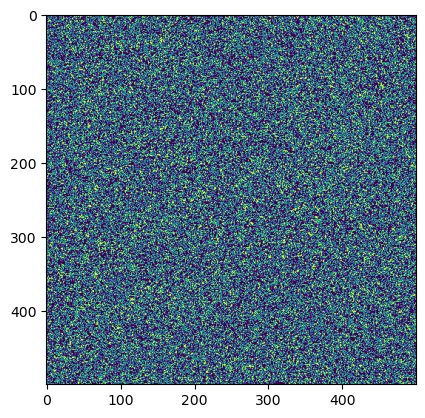

In [278]:
plt.imshow(layer3.astype(bool)[0])

In [279]:
uniform_dist = np.concatenate([layer1, layer2, layer3])

uniform_dist.shape

(3, 500, 500)

In [305]:
rad_ = 500

son = sonar.Sonar(linear_steps=rad_, max_radius=rad_, normalize=True)
#radii, 
co_occurrence_test = son.co_occurrence_from_tensor(hists=uniform_dist, interpolate=True)


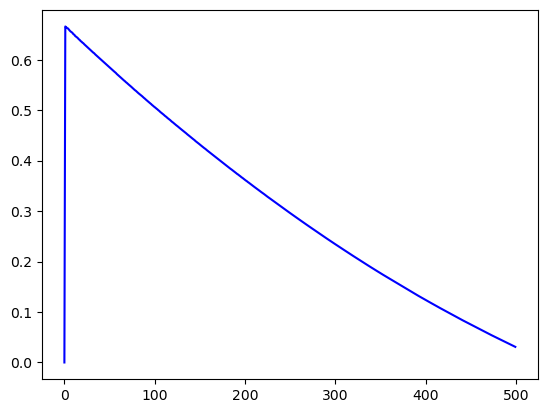

In [306]:

plt.plot(co_occurrence_test[0,1], color = 'blue')

In [287]:
co_occurrence_test.shape

(3, 3, 500)

In [284]:
1/16

0.0625

In [301]:
for rad in range(500):
    co_occurrence_test[:,:,rad] = co_occurrence_test[:,:,rad]*2*math.pi*rad

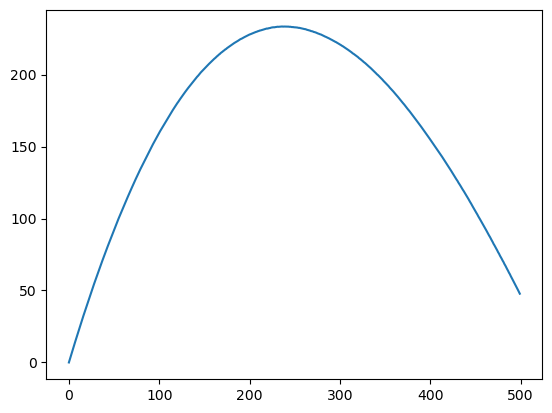

In [303]:
plt.plot(co_occurrence_test[1,1])

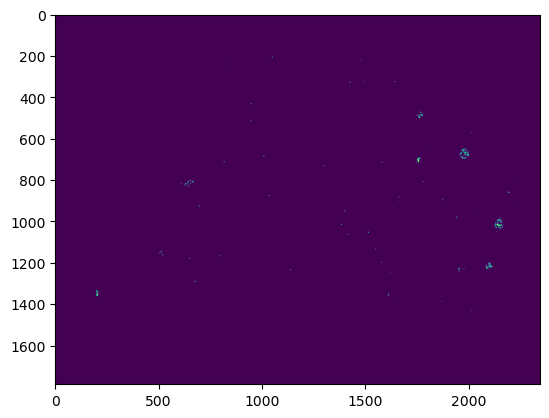

In [310]:
plt.imshow(rescaled[6])

76427.0
696597.0
4112.0
3774.0
4405.0
2195.0
7873.0
547.0
249.0
56161.0
8143.0
1017.0
222.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, 'Acinar-i'),
  Text(1, 0, 'Acinar-s'),
  Text(2, 0, 'Acinar-REG+'),
  Text(3, 0, 'Activated Stellate'),
  Text(4, 0, 'Quiescent Stellate'),
  Text(5, 0, 'Alpha'),
  Text(6, 0, 'Beta'),
  Text(7, 0, 'Gamma (PP)'),
  Text(8, 0, 'Delta'),
  Text(9, 0, 'Ductal'),
  Text(10, 0, 'MUC5B+ Ductal (PDG)'),
  Text(11, 0, 'MHC Class II'),
  Text(12, 0, 'Schwan')])

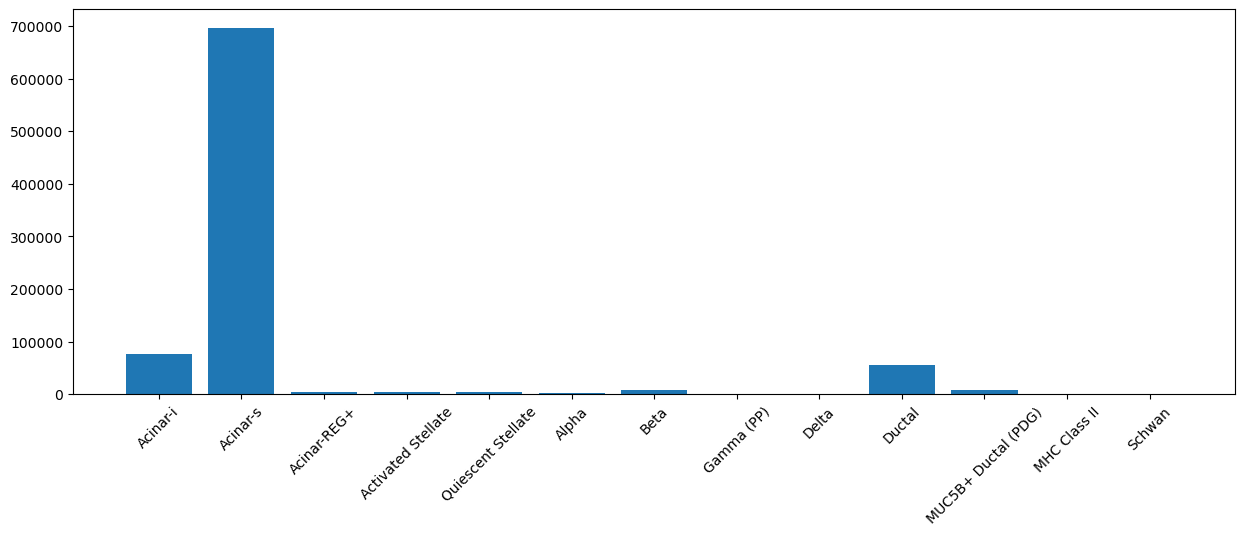

In [68]:
plt.figure(figsize=[15,5])
tissue_pixels = []
for i in range(1,14):
    pix_agreg = np.sum(rescaled[i])
    tissue_pixels.append(pix_agreg)
    print(pix_agreg)

plt.bar(cluster_labels[1:14],tissue_pixels)
plt.xticks(rotation=45)

In [77]:
sum(tissue_pixels)

861722.0

Probability distribution

In [79]:
probab_distr = []
for cell_type in tissue_pixels:
    p_cell_type = cell_type/sum(tissue_pixels)
    probab_distr.append(p_cell_type)
print(probab_distr)

[0.08869101636026468, 0.8083778759275033, 0.0047718405703927715, 0.0043796027024957, 0.005111857420374552, 0.0025472252072013942, 0.009136357201046276, 0.0006347754844369762, 0.0002889562991312744, 0.06517299082534739, 0.00944968330853802, 0.0011801950048855663, 0.00025762368838210003]


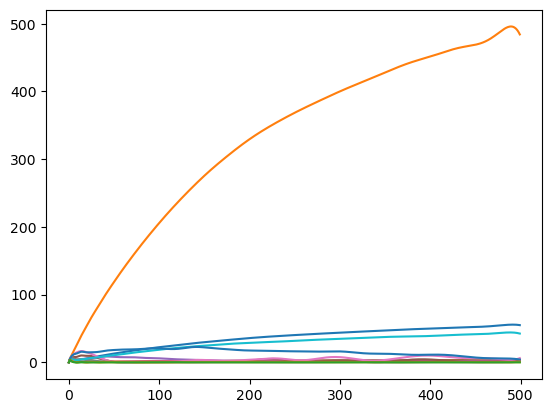

In [104]:
for rad in range(500):
    cooc_template_changed[:,:,rad] = cooc_template_[:,:,rad]*2*math.pi*rad

for i in range(1,14):
    # plt.plot(cooc_template_[6,7])
    plt.plot(cooc_template_changed[i,i])

In [ ]:
# test with 3 uniformly distributed values

co_occurrence_test

In [313]:
scipy.stats.binomtest(int(cooc_template_changed[6,6][200]), int(200*2*math.pi), p=probab_distr[6])

BinomTestResult(k=2, n=1256, alternative='two-sided', statistic=0.0015923566878980893, pvalue=0.0015561304470760793)

In [124]:
list_glob = []

for i in 500:
    list_local = []
    for i in 16:
        list_local.append
    result = list_local.stats
    list_glob.append(result)

plot(list_glob)


SyntaxError: invalid syntax (2862208826.py, line 10)